In [2]:
import warnings
import itertools
import numpy
import matplotlib
import matplotlib.pyplot as pyplot
import pandas
import statsmodels.api as statsmodels_api
import pylab

In [3]:
warnings.filterwarnings("ignore")
pyplot.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [4]:
imacec_df = pandas.read_excel("input.xls", skiprows=[0,1], index_col="Periodo")

In [5]:
imacec_df.columns = ["imacec", "imacec_minero", "imacec_no_minero", "imacec_costo_factores"]

In [29]:
def imacec_sarima(imacec_df = imacec_df, column = "imacec"):
    pylab.rcParams['figure.figsize'] = 18,8
    decomposition = statsmodels_api.tsa.seasonal_decompose(imacec_df[column], model='additive')
    fig = decomposition.plot()
    pyplot.show()

    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    sarimax_tuple_array = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = statsmodels_api.tsa.statespace.SARIMAX(imacec_df[column],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                #print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
                sarimax_tuple_array.append((param,param_seasonal,results.aic))
            except: 
                continue

    # best fit parameter
    sorted_sarimax_results = sorted(sarimax_tuple_array, key = lambda x : x[2])[0:5]

    mod = statsmodels_api.tsa.statespace.SARIMAX(imacec_df[column],
                                    order=sorted_sarimax_results[0][0],
                                    seasonal_order=sorted_sarimax_results[0][1],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])

    results.plot_diagnostics(figsize=(18, 8))
    pyplot.show()

    imasec_start_year = str(imacec_df[column].index.min().year)

    pred = results.get_prediction(start=pandas.to_datetime('2018-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = imacec_df[column][imasec_start_year:].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 8))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    pyplot.legend()
    pyplot.show()

    y_forecasted = pred.predicted_mean
    y_truth = imacec_df[column]['2018-01-01':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error is {}'.format(round(numpy.sqrt(mse), 2)))

    pred_uc = results.get_forecast(steps=24)
    pred_ci = pred_uc.conf_int()
    ax = imacec_df[column].plot(label='observed', figsize=(20, 8))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    pyplot.legend()
    pyplot.show()

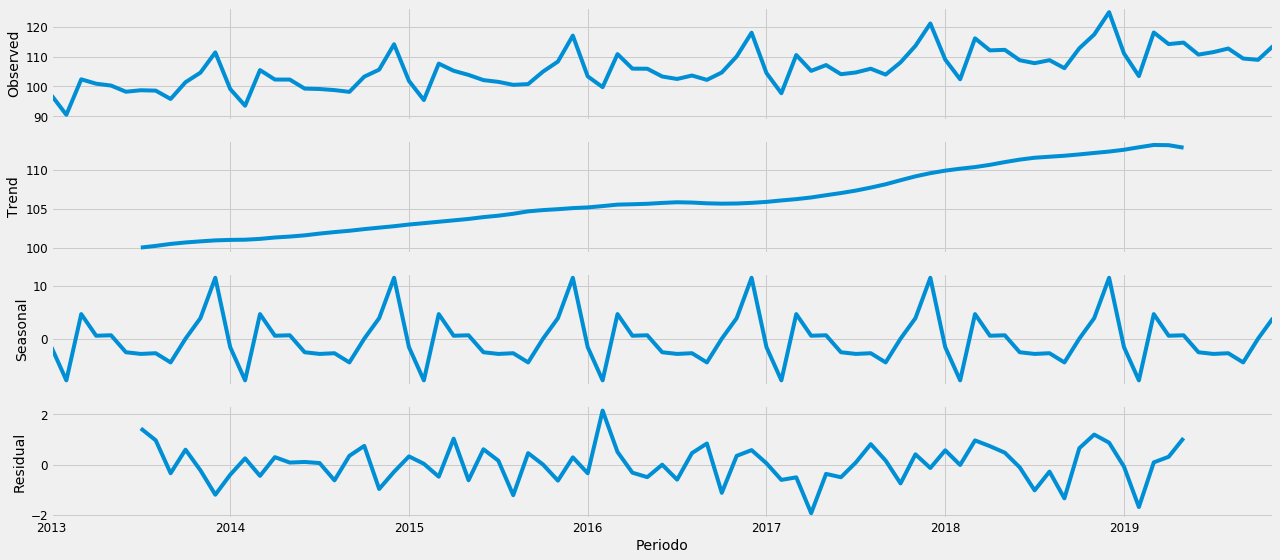

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3204      0.144     -2.229      0.026      -0.602      -0.039
ma.S.L12      -0.6413      0.234     -2.742      0.006      -1.100      -0.183
sigma2         1.8870      0.299      6.313      0.000       1.301       2.473


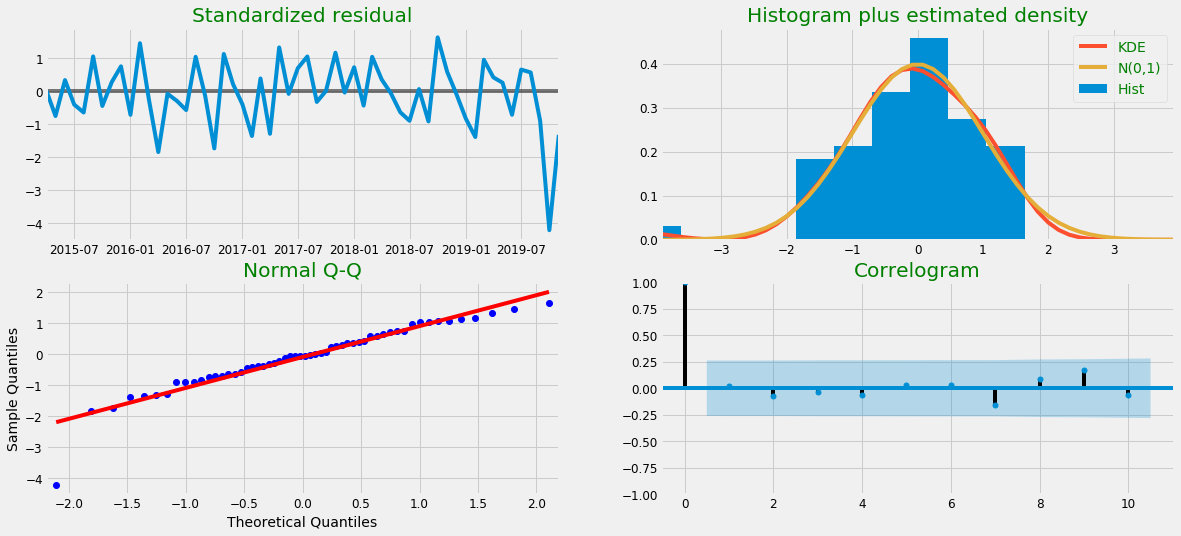

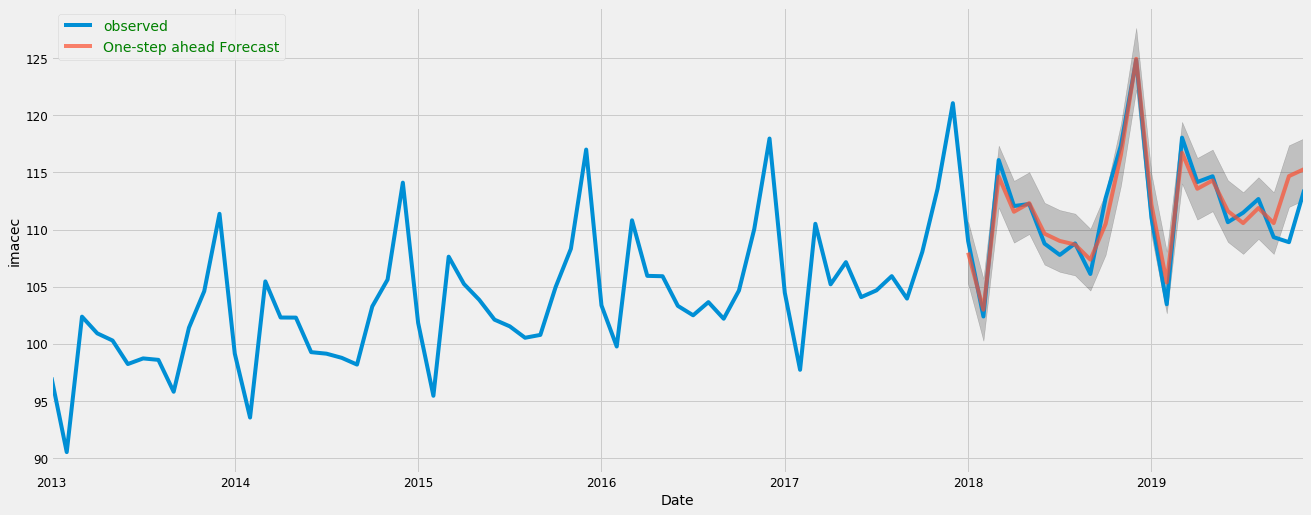

The Mean Squared Error is 2.66
The Root Mean Squared Error is 1.63


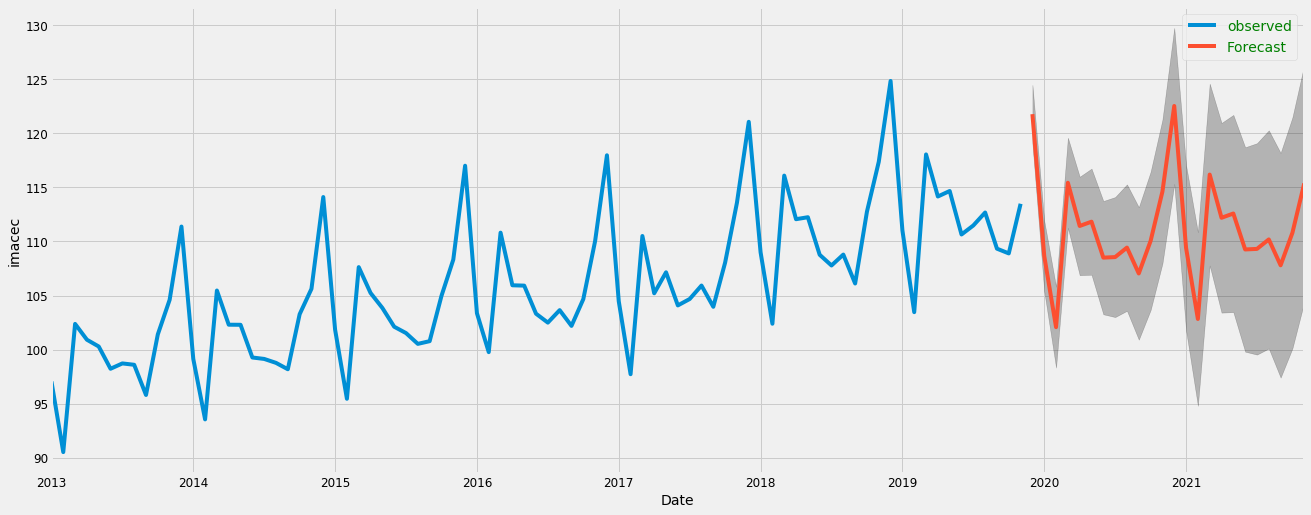

In [30]:
imacec_sarima(imacec_df=imacec_df, column=imacec_df.columns[0])

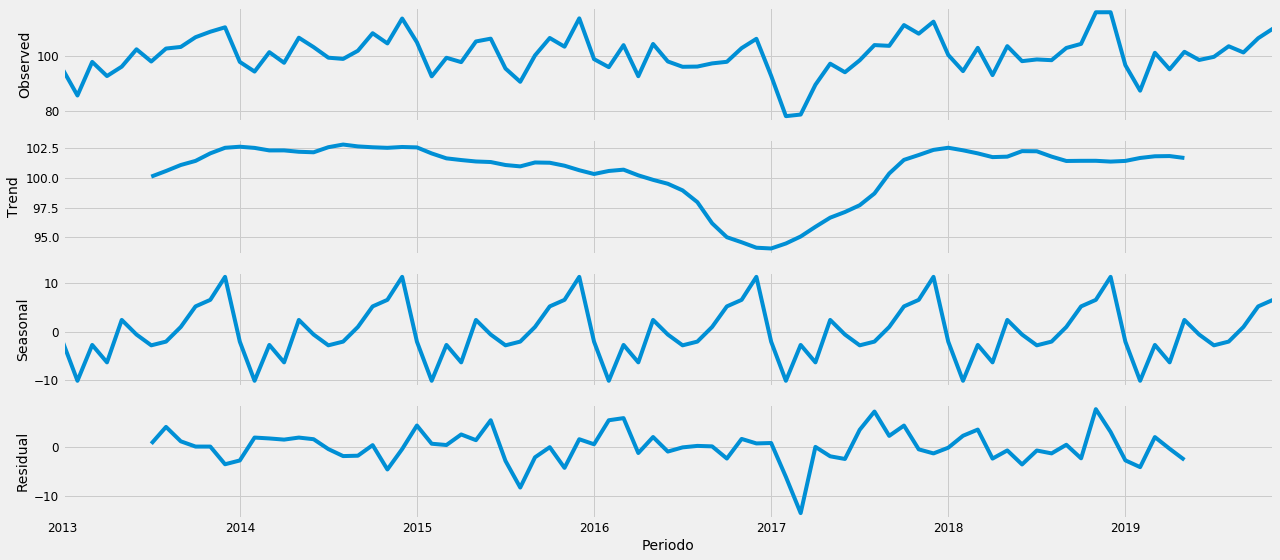

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4862      0.090     -5.406      0.000      -0.662      -0.310
ma.S.L12      -1.0000   2905.538     -0.000      1.000   -5695.749    5693.749
sigma2        18.0118   5.23e+04      0.000      1.000   -1.03e+05    1.03e+05


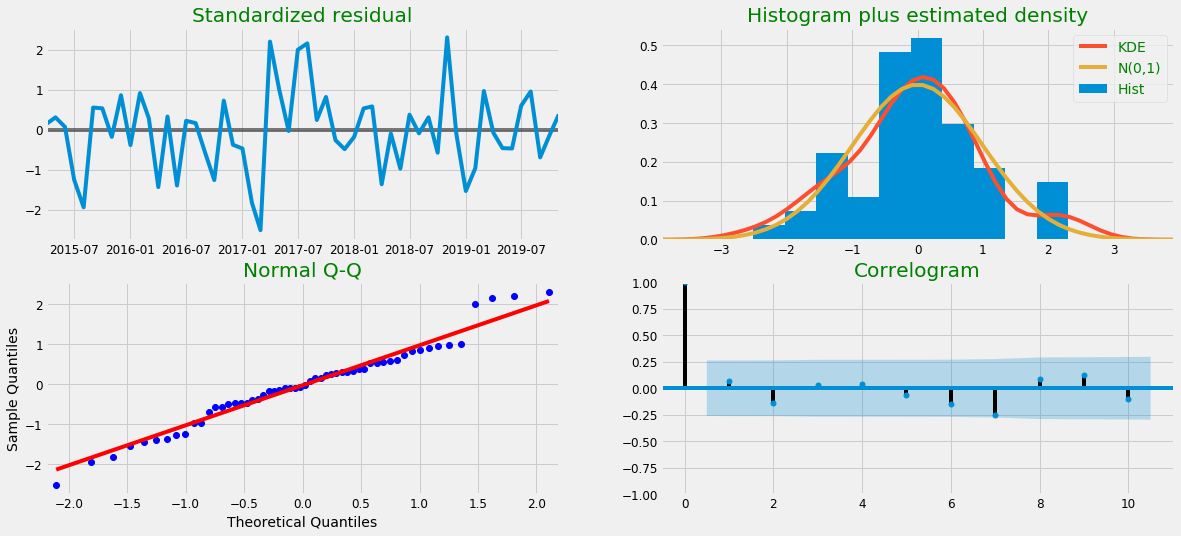

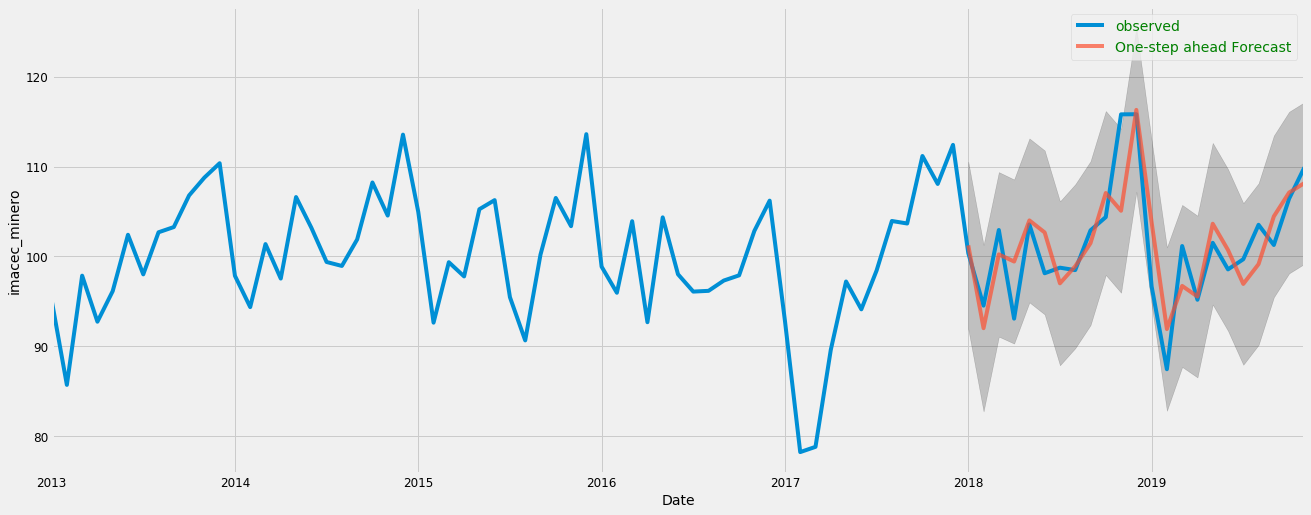

The Mean Squared Error is 14.91
The Root Mean Squared Error is 3.86


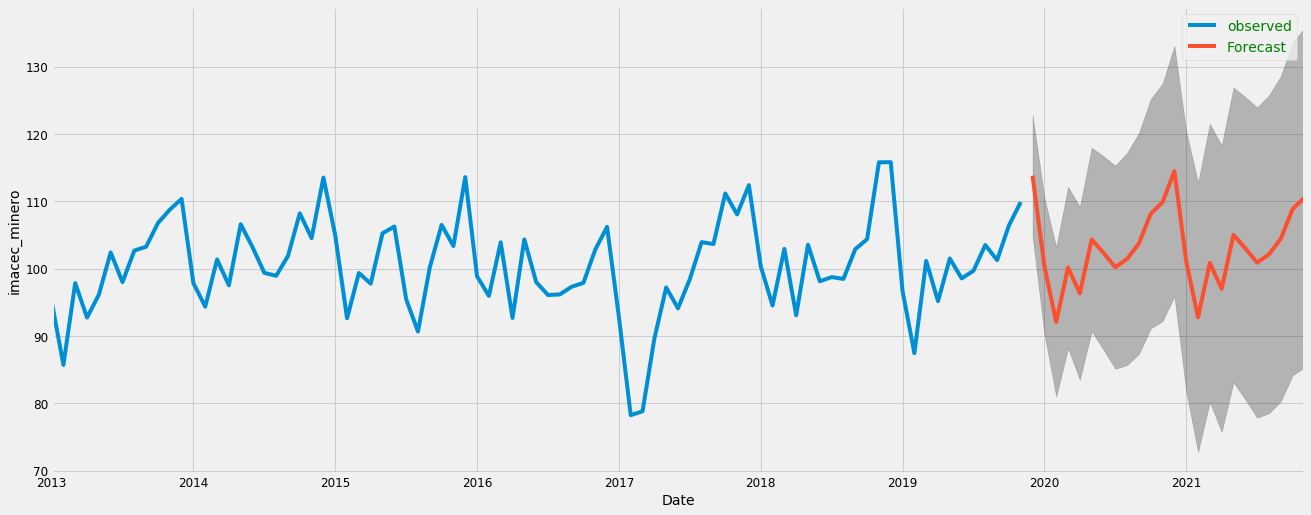

In [31]:
imacec_sarima(imacec_df=imacec_df, column=imacec_df.columns[1])

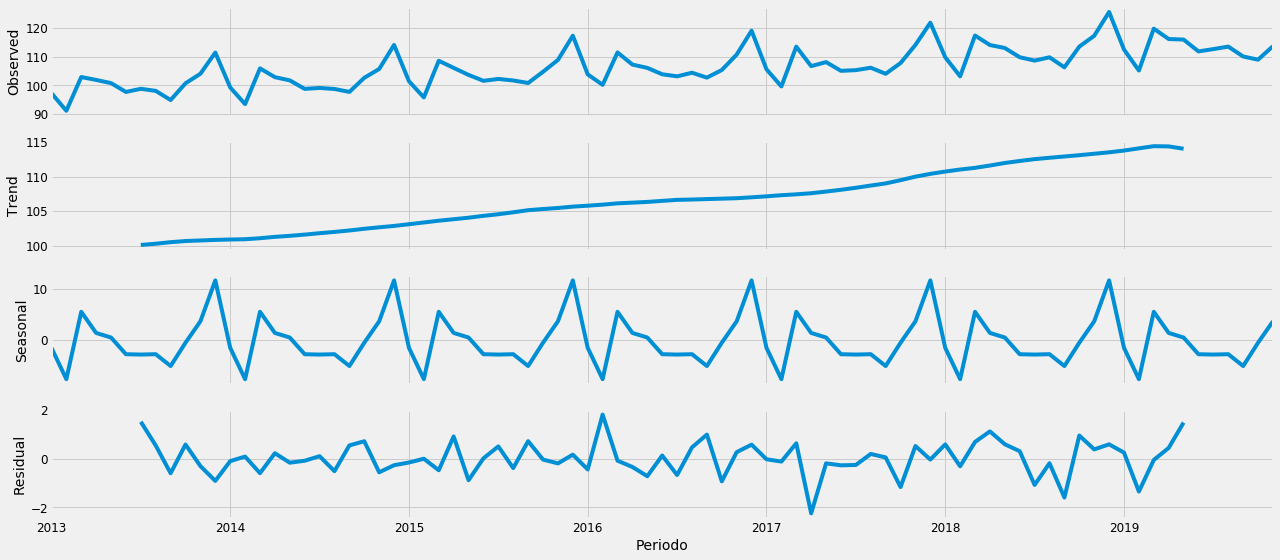

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4237      0.114     -3.733      0.000      -0.646      -0.201
ma.S.L12      -1.4196      0.454     -3.127      0.002      -2.309      -0.530
sigma2         1.0094      0.553      1.827      0.068      -0.074       2.092


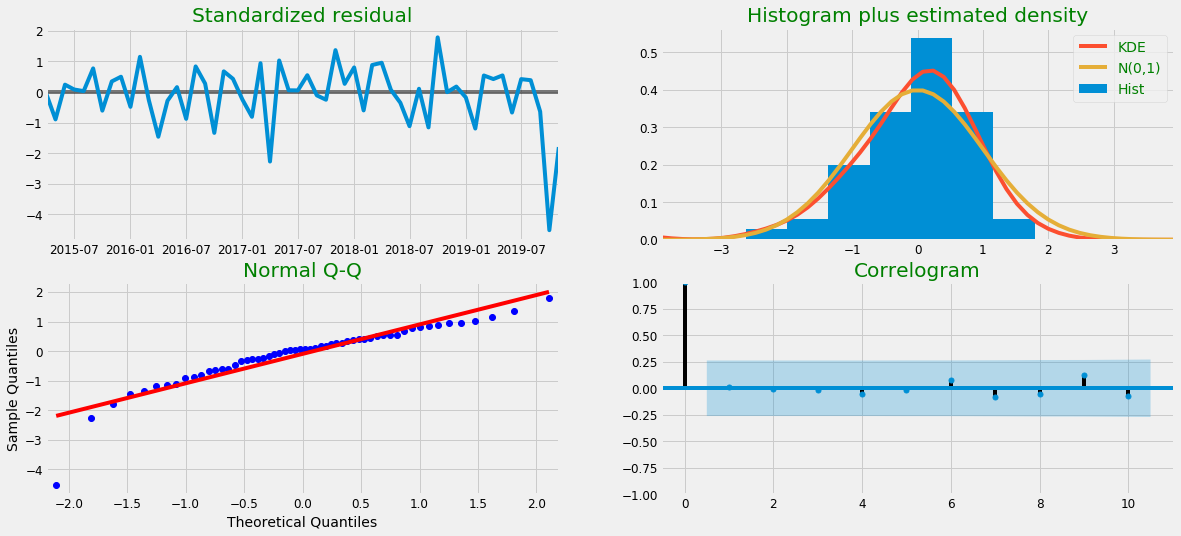

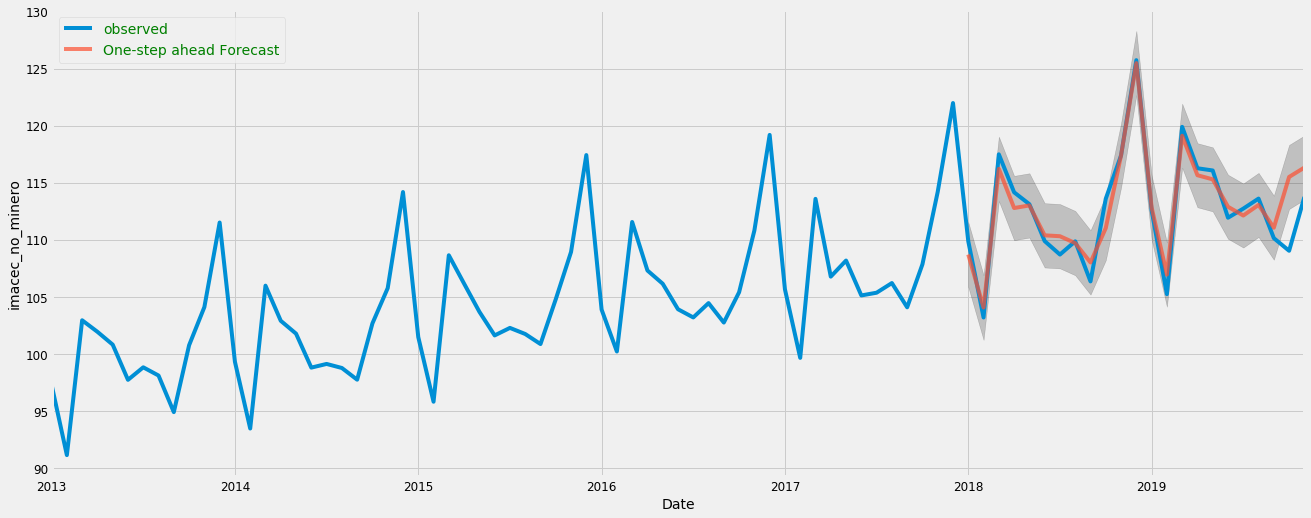

The Mean Squared Error is 3.19
The Root Mean Squared Error is 1.79


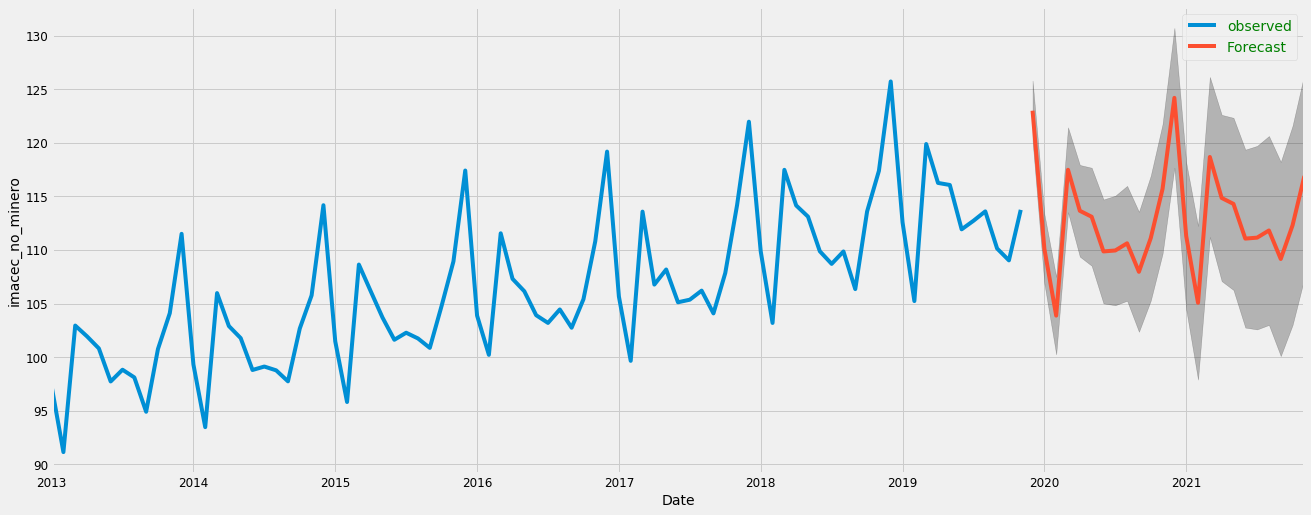

In [32]:
imacec_sarima(imacec_df=imacec_df, column=imacec_df.columns[2])

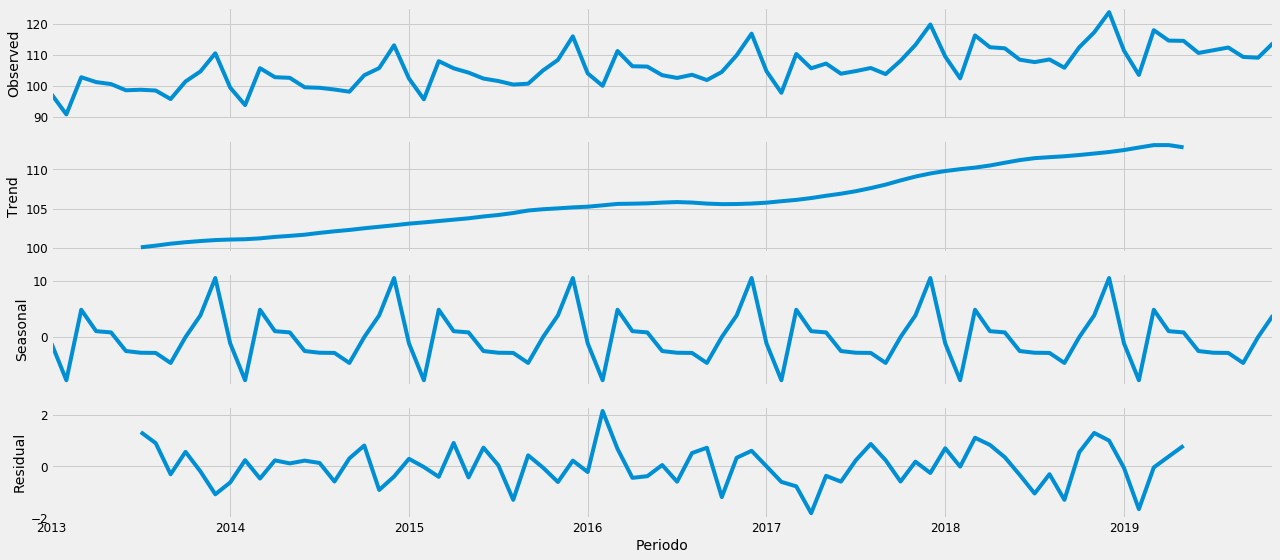

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6578      0.167      3.937      0.000       0.330       0.985
ma.L1         -1.0000    666.701     -0.001      0.999   -1307.710    1305.710
ma.S.L12      -0.6581      0.215     -3.068      0.002      -1.079      -0.238
sigma2         1.6207   1080.441      0.002      0.999   -2116.004    2119.245


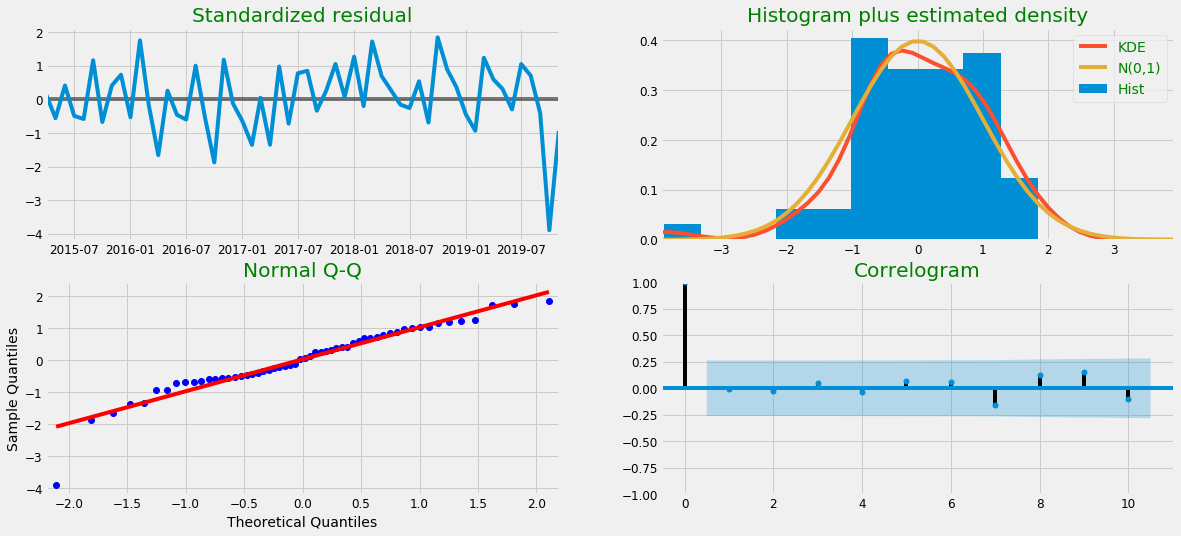

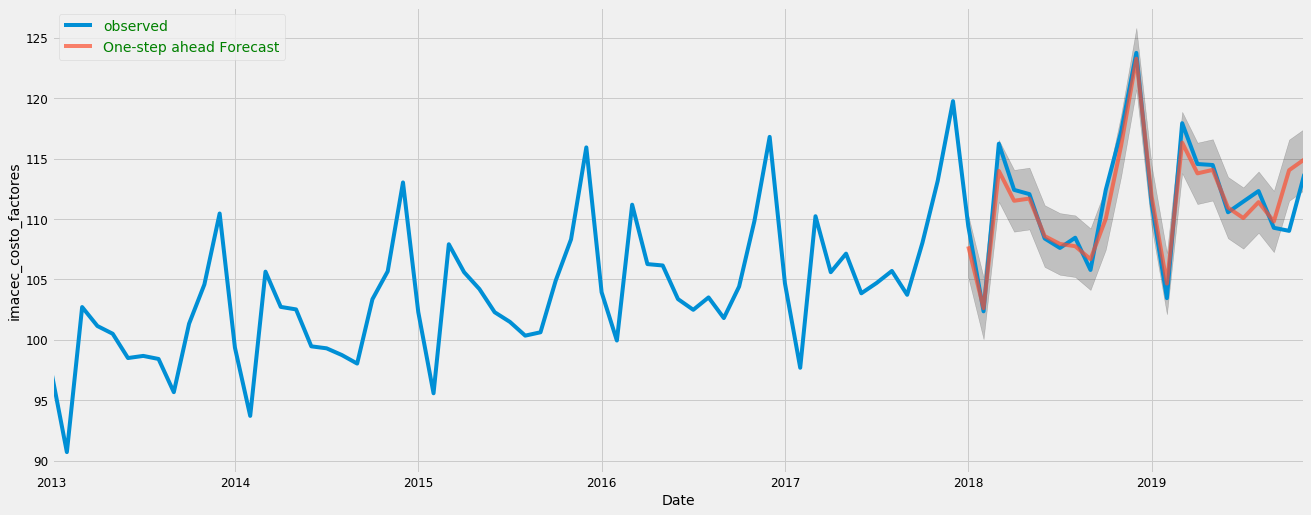

The Mean Squared Error is 2.28
The Root Mean Squared Error is 1.51


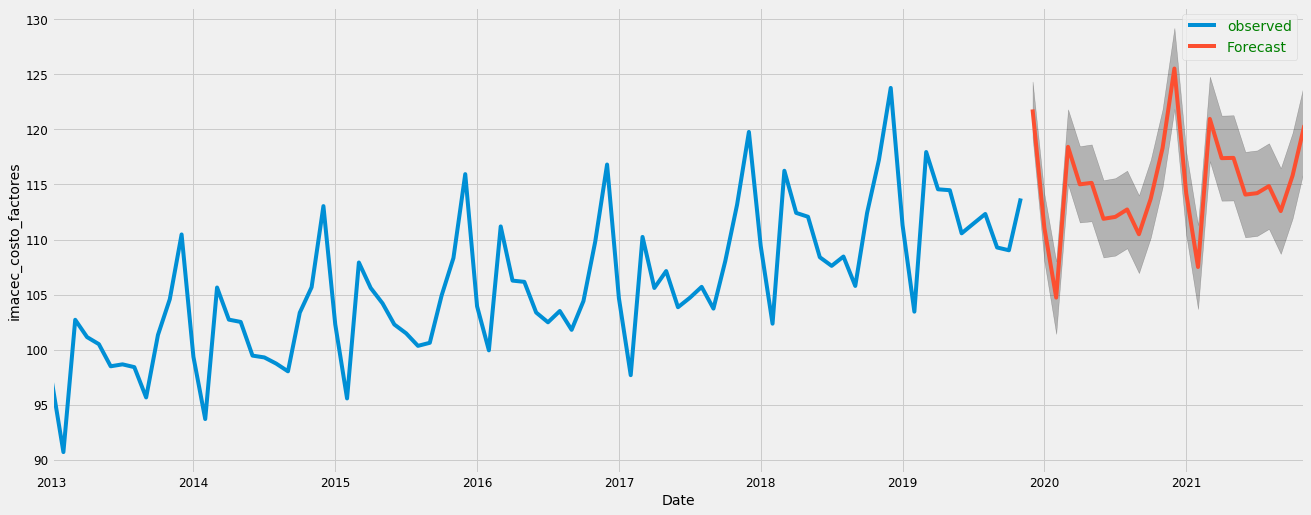

In [33]:
imacec_sarima(imacec_df=imacec_df, column=imacec_df.columns[3])